# ENSF 611 Project
## Kaggle Competition - House Prices<br>
Author: Deylin Yiao

In [1]:
import sys
print("Python version:", sys.version)

import pandas as pd
print("pandas version:", pd.__version__)

import numpy as np
print("NumPy version:", np.__version__)

import sklearn
print("scikit-learn version:", sklearn.__version__)

import matplotlib
import matplotlib.pyplot as plt
print("matplotlib version:", matplotlib.__version__)

import seaborn as sns
print("seaborn version:", sns.__version__)

import xgboost as xgb
print("XGBoost version:", xgb.__version__)

Python version: 3.8.8 (default, Apr 13 2021, 15:08:03) [MSC v.1916 64 bit (AMD64)]
pandas version: 1.2.4
NumPy version: 1.16.6
scikit-learn version: 1.0.1
matplotlib version: 3.3.4
seaborn version: 0.11.1
XGBoost version: 1.3.3


In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 20)

### 0. Introduction
The Kaggle competition provides an excel file which contains a house current price and 79 different variables associated with each house. The objective of this competition is to use ML models to determine the correlation between the 79 features and predicting the house based on the features.<br>
The jupyter notebook will be based off of the second lab of ENSF 611.


### 1. Loading the House Price Data

In [3]:
house_price_train = pd.read_csv(r'house-prices-advanced-regression-techniques\train.csv').fillna(np.nan)

In [4]:
house_price_train.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

As seen here, the house price feature matrix is extensive, with 79 features and 1460 samples. The features contain a mix of integer, float and string values.<br>
The string value requires encoding, therefore making it mandatory to invoke OneHotEncoder for nominal encoding and OrdinalEncoding for features with ranked strings.

From the above information, there are a few features with majority or a significant amount of null values. Therefore the following features will be dropped (there is a total of 1460 samples):
- Alley (only 91 non-null values)
- FireplaceQu (770 non-null values, slightly above half of values are non-null)
- PoolQC(Only 7 values are non-null)
- MiscFeature(54 values are non-null)


In [5]:
y = house_price_train.iloc[:,-1]
X = house_price_train.drop(columns=['Id', 'SalePrice', 'Alley',
                                    'FireplaceQu', 'PoolQC', 'MiscFeature'])

In [6]:
print("Target Vector Shape:", y.shape)
print("Feature Matrix Shape:", X.shape)

Target Vector Shape: (1460,)
Feature Matrix Shape: (1460, 75)


### 2. Data Inspection
The features and target given from the house prices dataset should be inspected to give an idea of how
the features could correlate to the house prices.

#### 2.1 Range in numerical features
We can inspect the range of the features with numerical values to see if the features given are within
the same scale. Therefore the minimum and maximum of each feature will be presented.

In [7]:
numerical_df = X.select_dtypes(include=['int64', 'float64'])
min_max_df = pd.DataFrame({"Minimum Values": numerical_df.min(axis=0), "Maximum Values:": numerical_df.max(axis=0)})
pd.set_option('display.max_rows', None)
print(min_max_df)

               Minimum Values  Maximum Values:
MSSubClass               20.0            190.0
LotFrontage              21.0            313.0
LotArea                1300.0         215245.0
OverallQual               1.0             10.0
OverallCond               1.0              9.0
YearBuilt              1872.0           2010.0
YearRemodAdd           1950.0           2010.0
MasVnrArea                0.0           1600.0
BsmtFinSF1                0.0           5644.0
BsmtFinSF2                0.0           1474.0
BsmtUnfSF                 0.0           2336.0
TotalBsmtSF               0.0           6110.0
1stFlrSF                334.0           4692.0
2ndFlrSF                  0.0           2065.0
LowQualFinSF              0.0            572.0
GrLivArea               334.0           5642.0
BsmtFullBath              0.0              3.0
BsmtHalfBath              0.0              2.0
FullBath                  0.0              3.0
HalfBath                  0.0              2.0
BedroomAbvGr 

The ranges of the features do vary quite a bit, with some features going between 0 and the double digits, and
some features going as high within the hundreds of thousands. Therefore, especially with range sensitive models such as SVR, StandardScaler method will be applied to the preprocessing section.

#### 2.2 Boxplot of Features
In comparison to Lab 2, the boxplot of features cannot be easily created as all features have different units and meanings, as well as plotting 79 features (if applicable) is exceedingly large and noisy. Therefore, as an example and an attempt to create meaningful boxplots, a boxplot for features with square footage (excluding LotArea as it is massive in comparison to other features of the same unit) and a boxplot for dimensionless units (i.e. grades, quality, quantity of fireplaces) will be created.

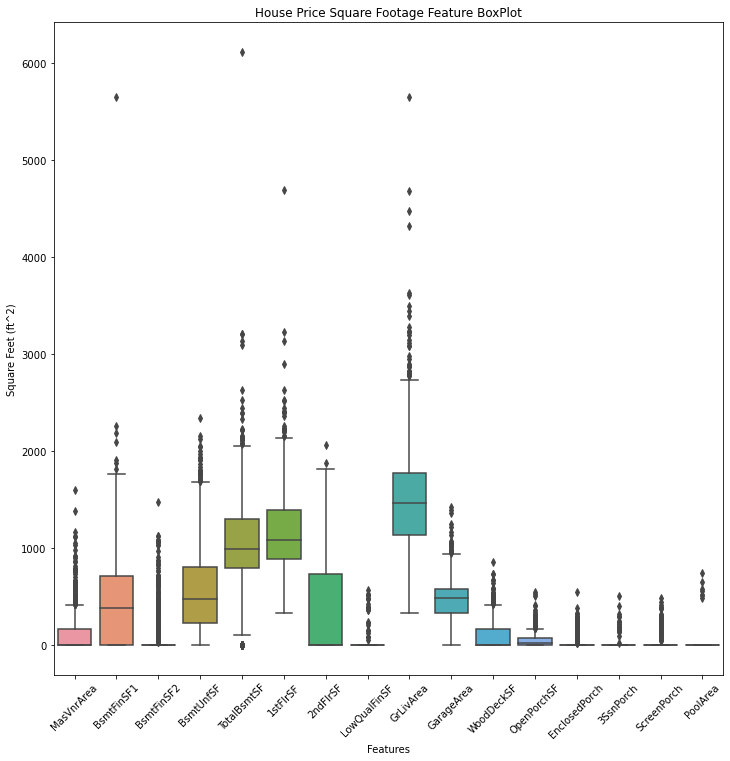

In [8]:
X_sqft = X[['MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
            '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'GarageArea', 
            'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch',
            'PoolArea']]
fig, ax = plt.subplots(figsize=(12,12))
plt.setp(ax.get_xticklabels(), rotation=45)
ax = sns.boxplot(data=X_sqft)
ax.set(xlabel = "Features", ylabel="Square Feet (ft^2)", title="House Price Square Footage Feature BoxPlot");


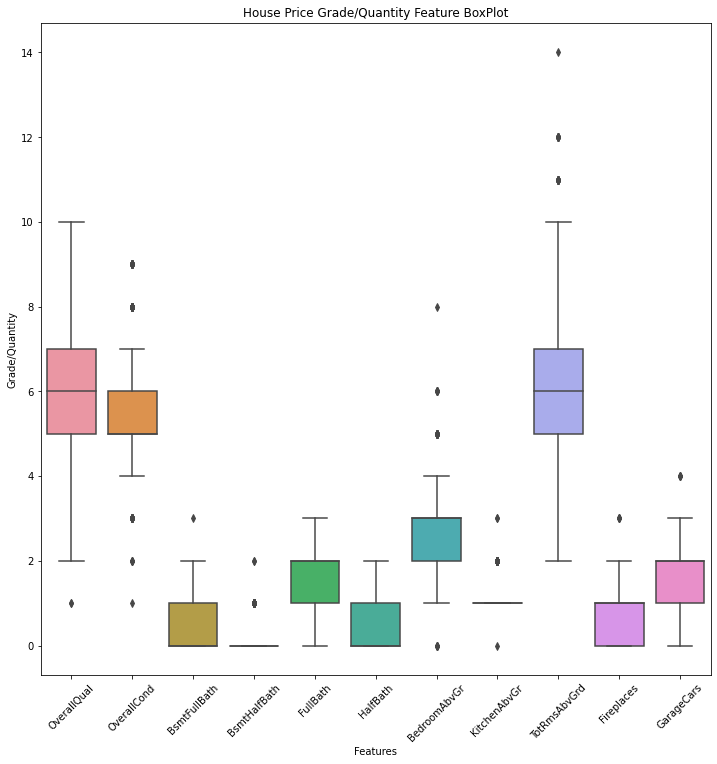

In [9]:
X_dimless = X[['OverallQual', 'OverallCond', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 
               'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
               'GarageCars']]
fig, ax = plt.subplots(figsize=(12,12))
plt.setp(ax.get_xticklabels(), rotation=45)
ax = sns.boxplot(data=X_dimless)
ax.set(xlabel = "Features", ylabel="Grade/Quantity", title="House Price Grade/Quantity Feature BoxPlot");

#### 2.3 Correlation Heatmap of Features
Heatmaps allows for the observation any feature correlations, as models benefit the most when features are uncorrelated:

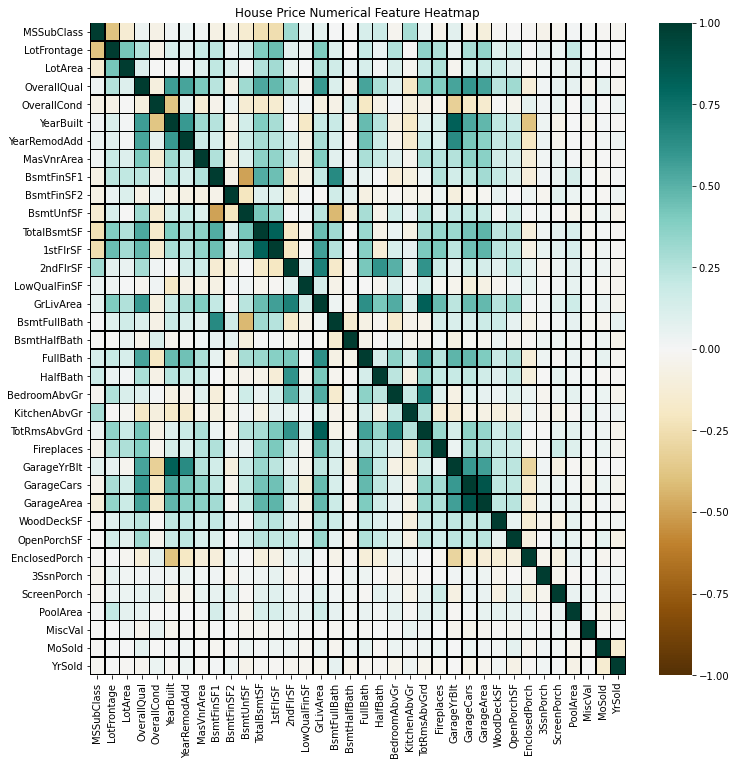

In [10]:
correlated_data = X.corr()
fig, ax = plt.subplots(figsize=(12,12))
ax.set_title("House Price Numerical Feature Heatmap")
sns.heatmap(data=correlated_data, vmin=-1, vmax=1, cmap="BrBG", ax=ax, linecolor='black', linewidth=0.5);

From observation, most features do not exhibit strong linear correlations with one another. There are a few features that exhibit stronger linear correlation (GarageYrBlt&YearBuilt, TotRmsAbvGrd&GrLivArea, GarageArea&GarageCars, BsmtUnfSF&BsmtFinSF1), but they make up an extreme minority compared to the total correlations.

#### 2.4 Histogram of Target Variable
A histogram of house prices will present the distribution of house prices, and how many samples of each house price is avaible in the training set.

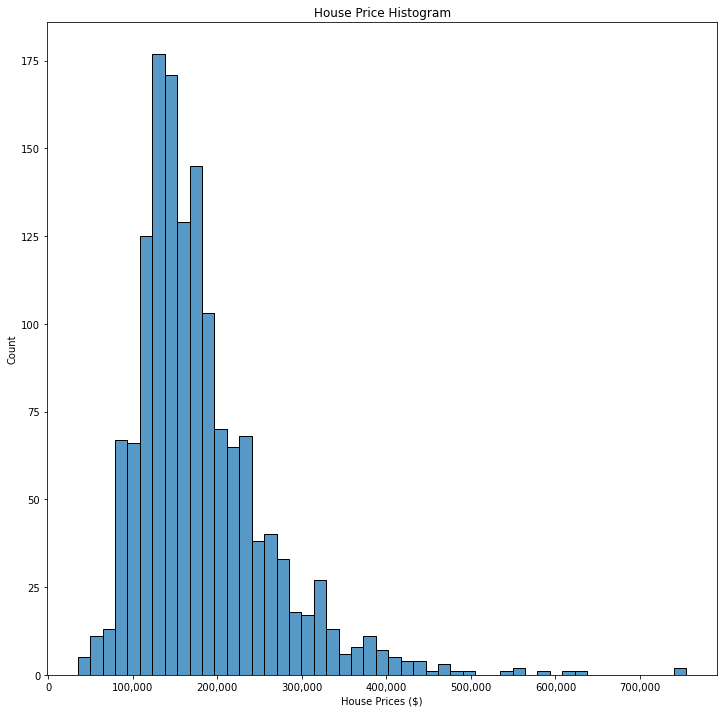

In [11]:
from matplotlib.ticker import FuncFormatter
fig, ax = plt.subplots(figsize=(12,12))
ax.set_title("House Price Numerical Feature Heatmap")
plot = sns.histplot(y, ax=ax)
plot.set(xlabel = "House Prices ($)", ylabel = "Count", title = "House Price Histogram");
plot.xaxis.set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))

Most of the houses have prices are within 100,000-200,000 dollars range, higher priced houses gradually decreasing up to and over 700,000 dollars.

### 3. Data Preprocessing
Before any kind of plotting or data inspection can be done, the dataset will have to be encoded to retrieve the full correlation between features.<br>
Below are the given features that require encoding:

In [138]:
X_req_ordinal = X.select_dtypes(include='object')
print(X_req_ordinal.columns)

Index(['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Fence', 'SaleType', 'SaleCondition'],
      dtype='object')


OneHotEncoder will be required for most of the features, but there are a few features that would benefit from having a ranking order (i.e. Quality). Below is a list of the features that will be encoded using OrdinalEncoder and the rankable categories, worst to best (Any NaN/NA values have been converted to -1):<br>
LotShape = {IR3, IR2, IR1, REG}<br>
LandSlope = {Sev, Mod, Gtl}<br>
ExterQual = {Po, Fa, TA, Gd, Ex}<br>
ExterCond = {Po, Fa, TA, Gd, Ex}<br>
BsmtQual = {Po, Fa, TA, Gd, Ex}<br>
BsmtCond = {Po, Fa, TA, Gd, Ex}<br>
BsmtExposure = {No, Mn, Av, Gd}<br>
BsmtFinType1 = {Unf, LwQ, Rec, BLQ, ALQ, GLQ}<br>
BsmtFinType2 = {Unf, LwQ, Rec, BLQ, ALQ, GLQ}<br>
HeatingQC = {Po, Fa, TA, Gd, Ex}<br>
CentralAir = {N, Yes}<br>
KitchenQual = {Po, Fa, TA, Gd, Ex}<br>
FireplaceQu = {Po, Fa, TA, Gd, Ex}<br>
GarageFinish = {Unf, RFn, Fin}<br>
GarageQual = {Po, Fa, TA, Gd, Ex}<br>
GarageCond = {Po, Fa, TA, Gd, Ex}<br>
PoolQC = {Po, Fa, TA, Gd, Ex}<br>

In [139]:
# Implementation of the OrdinalEncoder
from sklearn.preprocessing import OrdinalEncoder

# Custom preprocessing: GarageYrBlt is a numerical feature with year input, and therefore cannot be put through a simpleInputer,
# Therefore null GarageYrBlt will be equated to YearBuilt as having a year value of 0 would skew the scaler.
for index in range(0, 1460):
    if(np.isnan(X['GarageYrBlt'][index])):
        X['GarageYrBlt'][index] = X['YearBuilt'][index]

# Some features have the same range of quality/condition, therefore we can use some
# quality/condition list more than once
lot_shape = ['IR3', 'IR2', 'IR1', 'Reg']
land_slope = ['Sev', 'Mod', 'Gtl']
qual_cond = ['Po', 'Fa', 'TA', 'Gd', 'Ex']
bsmt_exposure = ['No', 'Mn', 'Av', 'Gd']
bsmt_fin = ['Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', "GLQ"]
central_air = ['N', 'Y']
garage_fin = ['Unf', 'RFn', 'Fin']

# List of features requiring the OrdinalEncoder
ordinal_column_list = ['LotShape', 'LandSlope', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond',
                       'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC','CentralAir', 'KitchenQual',
                       'GarageFinish', 'GarageQual', 'GarageCond']

# Retrieving ordinal features from original matrix
X_ordinal_part = X[ordinal_column_list]

# Ordinal catergories for each column (in the same order as X_ordinal_column_list)
ordinal_categories = [lot_shape, land_slope, qual_cond, qual_cond, qual_cond, qual_cond,
                      bsmt_exposure, bsmt_fin, bsmt_fin,  qual_cond, central_air, qual_cond,
                    garage_fin, qual_cond, qual_cond]

# Encoding the Ordinal dataset, any NaN values have been converted to -1
ordinal_model = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1, categories=ordinal_categories)
X_ordinal = ordinal_model.fit_transform(X_ordinal_part)
print(X_ordinal.shape)

(1460, 15)


<ipython-input-139-2916a9ecc03c>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['GarageYrBlt'][index] = X['YearBuilt'][index]


We will now preprocess the rest of the features using scalers and one hot encoder via ColumnTransformer method

In [140]:
# Dropping the ordinal encoded features
X_clmntrans = X.drop(columns=ordinal_column_list)

All features with word values will be converted into numerical value via OneHotEncoder, and most features with numerical values will be placed through a scaler to adjust the data for certain ML models (i.e. SVR). However, some features with numerical values will not be scaled as one feature (MSSubclass) uses numbers as a identifier for the dwelling type and will be encoded through OneHotEncoder as such:

In [141]:
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline

# Features to be converted through OneHotEncoder
ohe_feature_list = ['MSSubClass', 'MSZoning', 'Street', 'LandContour',
                        'Utilities', 'LotConfig', 'Neighborhood', 'Condition1', 'Condition2',
                        'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
                        'Exterior2nd', 'MasVnrType', 'Foundation', 'Heating', 'Electrical',
                        'Functional', 'GarageType', 'PavedDrive', 'SaleType', 'SaleCondition']

# Features to be converted through StandardScaler
scaling_feature_list = ['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
                        'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'TotalBsmtSF',
                        '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath',
                        'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
                        'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea',
                        'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch',
                        'PoolArea', 'MiscVal', 'MoSold', 'YrSold']

# Creating a pipeline for numerical features
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('scaler', StandardScaler())])

# Configuring the ColumnTransformer
ct_ohe_scaling = ColumnTransformer(
                                [ ("stdscl", numeric_transformer, scaling_feature_list),
                                 ("ohe", OneHotEncoder(sparse=False, handle_unknown='ignore'), ohe_feature_list)])


In [142]:
# Fitting, transforming and converting the transformed dataset to a Pandas DataFrame
ct_ohe_scaling.fit(X_clmntrans)
X_ohe_scl = ct_ohe_scaling.transform(X_clmntrans)
print(X_ohe_scl.shape)

(1460, 222)


In [143]:
# Combining the entire numpy array together (ColumnTransformed + Ordinal Encoded)
X_combined = np.concatenate([X_ohe_scl, X_ordinal], axis=1)
print(X_combined.shape)

(1460, 237)


### 4. Model Comparison
With the preprocessing complete, model testing and comparison can be executed to determine the model with the best validation score. The regression ML models that will be implemented for the competition will be:
- LinearRegression
- SVR
- RandomForestRegressor
- GradientBoostingRegressor
- XGBRegressor (xgboost)<br>

To compare validation, minimizing root-mean-squared-error (RMSE) will be the goal of the house price prediction. Adapting from Lab 2, the get_regressor_neg_rms will be used to to take advantage of cross-validation and returns a mean RMSE.

In [20]:
from sklearn.model_selection import cross_validate

def get_regressor_neg_rms(model, X, y, cv=7):
    '''Calculate train and validation score for regressor (model) using cross-validation
        
        score is negative root mean-squared error (rms).
        
        model (sklearn classifier): Regressor to train and evaluate
        X (numpy.array or pandas.DataFrame): Feature matrix
        y (numpy.array or pandas.Series): Target vector
        
        returns: mean training negative rms, mean validation negative rms
    
    '''
    
    
    #TODO: add function body here
    score = cross_validate(model, X, y, scoring='neg_root_mean_squared_error', cv=cv, return_train_score=True)
    train_score = score["train_score"].mean()
    test_score = score["test_score"].mean()
    
    return train_score, test_score

In [21]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

model_list = [LinearRegression(), SVR(), RandomForestRegressor(random_state=50), 
              GradientBoostingRegressor(random_state=50), xgb.XGBRegressor()]

#RMSE is in dollar unit, therefore will print RMSE to two decimal places
for model in model_list:
    train_score, test_score = get_regressor_neg_rms(model, X_combined, y)
    print("Model:", model)
    print("Training RMSE ={:.0f}".format(train_score))
    print("Validation RMSE ={:.0f}".format(test_score))

Model: LinearRegression()
Training RMSE =-22215
Validation RMSE =-122079389358893
Model: SVR()
Training RMSE =-81333
Validation RMSE =-80967
Model: RandomForestRegressor(random_state=50)
Training RMSE =-11138
Validation RMSE =-29849
Model: GradientBoostingRegressor(random_state=50)
Training RMSE =-14017
Validation RMSE =-25934
Model: XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None, gamma=None,
             gpu_id=None, importance_type='gain', interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             random_state=None, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=None)
Training RMSE =-1577
Validation RMSE =-31

From observation, the tested models generally shows signs of high variance. The linear model was implemented to show the progression of more robust model.<br> 

While it does seem the linear model training RMSE is better than the SVR model, the linear model RMSE differs greatly as the withheld test could carry different characteristics that the linear model was not able to capture well, especially since the linear model must be able to capture as much detail as possible of the 252 features (after scaling and encoding) which makes it rigid when a new sample with a different combination of features is used for prediction.<br>

The implementation of SVR have relatively consistent training and validation score, but in comparison to the decision tree ensemble models, the validation about 4x higher than the ensemble models, therefore the focus will be on the decision tree ensemble models.<br>

The random forest model, gradient boosting model and XGBoostRegressor model shows relatively high variance and overfitting as all models exhibit lower training RMSE versus the higher validation RMSE.<br>
The random forest model exhibits high variance as the training RMSE (-11138) is significantly less than the validation RMSE (-29849).<br>
Gradient boosting model also exhibits high variance as its training RMSE (-14017) and validation RMSE (-25934).<br>
The XGBRegressor method has a much lower RMSE which make the variance and overfitting effect as more pronounced than the random forest and gradient boosting 
model. The training RMSE (-1577) is significantly lower than the validation RMSE (-31034)<br>

While the gradient boosting model yielded the best RMSE, for the purposes of this project, XGBRegressor, GradientBoostingRegressor and RandomForestRegressor will be used as the model for hyperparameter tuning.


### 5. Finding a Better Model using GridSearchCV

#### 5.1 XGBoostRegressor
For the next portion, XGBRegressor will be used for hyperparameter tuning through the method GridSearchCV. Under the dmlc XGBoost documentation, there are a few parameters given to finely tune the model to prevent the overfitting currently happening. (reference URL: https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.XGBRegressor) and reading through this medium article (reference URL: https://medium.com/@juniormiranda_23768/ensemble-methods-tuning-a-xgboost-model-with-scikit-learn-54ff669f988a) These are the common parameters used for fine-tuning:
- learning_rate {0.01, 0.1, 0.2, 0.3, 0.4}
- max_depth {2, 3, 5, 7, 10}
- n_estimator {50, 100, 200, 300, 400}
- gamma {0, 0.1, 0.2, 0.3}
- colsample_bytree {0.1, 0.2, 0.3}
- lambda (L2 regularization) {0, 0.001, 0.01, 0.1, 1}
- alpha (L1 regularization) {0, 0.001, 0.01, 0.1, 1} <br>

In [22]:
from sklearn.model_selection import GridSearchCV
model_GSCV = xgb.XGBRegressor(verbosity=0)
full_param_list = {
    'learning_rate': [0.01, 0.1, 0.3, 0.5],
    'max_depth': [3, 7, 10],
    'gamma': [0, 0.1, 0.2, 0.3],
    'n_estimator': [50, 100, 200],
    'colsample_bytree': [0.1, 0.4, 0.7],
    'reg_lambda': [0.001, 0.01, 1],
    'reg_alpha': [0.001, 0.01, 1]
}

grid_search = GridSearchCV(estimator=model_GSCV, param_grid=full_param_list, scoring='neg_root_mean_squared_error')
grid_search.fit(X_combined, y)

GridSearchCV(estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=None,...
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=None, subsample=None,
                                    tree_method=None, validate_parameters=None,
                                    verbosity=0),
             param_grid={'colsam

In [23]:
print(grid_search.best_score_)
print(grid_search.best_params_)

-25536.585661019326
{'colsample_bytree': 0.4, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimator': 50, 'reg_alpha': 0.001, 'reg_lambda': 0.001}


#### 5.2 GradientBoostingRegressor

For the GradientBoostingRegressor(model with best initial RMSE), the following parameters will be used through GridSearchCV:

- min_samples_split {2, 5, 10}
- learning_rate {0.1, 0.4, 0.7}
- n_estimators {50, 100, 200, 400, 800}
- subsample {0.4, 0.8}
- max_depth {2, 5}
- max_features {0.1, 0.4, 1}

In [24]:
model_GB = GradientBoostingRegressor(random_state=50)
full_param_list_GB = {
    'min_samples_split': [2, 5, 10],
    'learning_rate': [0.1, 0.4, 0.7],
    'max_depth': [2, 5, 9],
    'n_estimators': [50, 100, 200, 400, 800],
    'subsample': [0.4, 0.8, 1],
    'max_features': [0.1, 0.4, 1]
}

grid_search_GB = GridSearchCV(estimator=model_GB, param_grid=full_param_list_GB, scoring='neg_root_mean_squared_error')
grid_search_GB.fit(X_combined, y)

GridSearchCV(estimator=GradientBoostingRegressor(random_state=50),
             param_grid={'learning_rate': [0.1, 0.4, 0.7],
                         'max_depth': [2, 5, 9], 'max_features': [0.1, 0.4, 1],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200, 400, 800],
                         'subsample': [0.4, 0.8, 1]},
             scoring='neg_root_mean_squared_error')

In [25]:
print(grid_search_GB.best_score_)
print(grid_search_GB.best_params_)

-24560.460378901345
{'learning_rate': 0.1, 'max_depth': 5, 'max_features': 0.4, 'min_samples_split': 2, 'n_estimators': 200, 'subsample': 0.8}


#### 5.3 RandomForestRegressor
For the RandomForestRegressor, the following parameters will be used through GridSearchCV:

- n_estimators {50, 100, 200, 400, 800}
- max_depth {2, 5, 9}
- max_features {0.1, 0.4, 1}
- bootstrap {True, False}
- min_sample_split {2, 5, 10}

In [26]:
model_RF = RandomForestRegressor(random_state=50)
full_param_list_RF = {
    'n_estimators': [50, 100, 200, 400, 800],
    'max_depth': [2, 5, 9],
    'max_features': [0.1, 0.4, 1],
    'bootstrap': [True, False],
    'min_samples_split': [2, 5, 10]
}

grid_search_RF = GridSearchCV(estimator=model_RF, param_grid=full_param_list_RF, scoring='neg_root_mean_squared_error')
grid_search_RF.fit(X_combined, y)

GridSearchCV(estimator=RandomForestRegressor(random_state=50),
             param_grid={'bootstrap': [True, False], 'max_depth': [2, 5, 9],
                         'max_features': [0.1, 0.4, 1],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200, 400, 800]},
             scoring='neg_root_mean_squared_error')

In [27]:
print(grid_search_RF.best_score_)
print(grid_search_RF.best_params_)

-28303.847963861994
{'bootstrap': False, 'max_depth': 9, 'max_features': 0.4, 'min_samples_split': 2, 'n_estimators': 100}


### 6. Determining and Retraining the Best Model
As seen from above, these are the best parameters for XGBoostRegressor. The best RMSE (-25537) is lower than the initial RMSE (-29138), therefore the these parameters will be used for the fine-tune XGBoostRegressor model.<br>

The gradient boosting decision tree model, with the optimal parameters have made a slight improvement to RMSE, from the initial RMSE (-26108) then slightly decreasing to the optimized hyperparameter RMSE(-24560).<br>

With the optimized parameters, the random forest regression model only slightly improved, with the initial RMSE (-29849) to the improved RMSE (-28304).

Each of the models have been recorded with their respective optimized parameter setting, but GradientBoostingRegressor will be used for the Kaggle competition.

In [121]:
best_XGB_model = xgb.XGBRegressor(reg_alpha=0.001, colsample_bytree=0.4,
                                  gamma=0, reg_lambda=0.001, learning_rate=0.1,
                                  max_depth=3, n_estimator=50)

In [29]:
best_GB_model = GradientBoostingRegressor(random_state=50, learning_rate=0.1, 
                                          max_depth=5, max_features=0.4,
                                          min_samples_split=2, n_estimators=200,
                                          subsample=0.8)

In [30]:
best_RF_model = RandomForestRegressor(random_state=50, bootstrap=False, max_features=0.4,
                                      min_samples_split=2, n_estimators=100)

In summary, out of all decision tree ensemble methods, GradientBoostingRegressor had the best validation score compared to RandomForestRegressor and XGBoostRegressor, therefore will be the model to use to predict the test dataset and submit to Kaggle. Below is a comparison of both the training RMSE and r2 score to make the RMSE error easier to understand.

In [144]:
#X_combined is the whole training data
best_GB_model.fit(X_combined, y)

GradientBoostingRegressor(max_depth=5, max_features=0.4, n_estimators=200,
                          random_state=50, subsample=0.8)

### 7. Best Model Evaluation
#### 7.1 Root Mean-Squared Error and R-Squared Score

In [145]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

y_pred = best_GB_model.predict(X_combined)
print("Training Data:\nRoot mean squared error = {0:.0f}, R-squared score = {1:.3f}"
      .format(mean_squared_error(y, y_pred, squared=False), r2_score(y, y_pred)))

Training Data:
Root mean squared error = 4825, R-squared score = 0.996


According to R-squared error, the GradientBoostingRegressor model has reached an r^2 score of 0.996 which is incredibly high, and could be signs of overfitting but is uncertain until we test it out of the test data as well.

In [146]:
# Kaggle included the test data in a seperate Excel, therefore all of the previous steps
# to preprocess the training data must be applied.
house_price_test = pd.read_csv(r'house-prices-advanced-regression-techniques\test.csv').fillna(np.nan)
print(house_price_test.shape)

# Seperating target vector and matrix features, excluding sparse features
X_test = house_price_test.drop(columns=['Id', 'Alley',
                                    'FireplaceQu', 'PoolQC', 'MiscFeature'])

# Ordinal Encoder
X_test_ordinal_part = X_test[ordinal_column_list]
X_test_ordinal = ordinal_model.fit_transform(X_test_ordinal_part)

# Dropping the ordinal encoded features
X_test_clmntrans = X_test.drop(columns=ordinal_column_list)

# Column Transfomer (StandardScaler-SimpleImputer & OneHotEncoder)
# Note that prediction should not be done again on test data to avoid skewing the scaler
X_test_ohe_scl = ct_ohe_scaling.transform(X_test_clmntrans)

# Combining the entire numpy array together (ColumnTransformed + Ordinal Encoded)
X_test_combined = np.concatenate([X_test_ohe_scl, X_test_ordinal], axis=1)

(1459, 80)


In [147]:
y_test_pred = best_XGB_model.predict(X_test_combined)

With the test dataset retrieved and preprocessed and predicted the house price using the GradientBoostingRegressor fitted to the train data, had yielded similar score to the training dataset. The house prices of the test dataset is not given to ensure teams will not input the test actual house prices. We will be implementing the actual vs predicted house prices and residual plot based on the training dataset.

#### 7.2 Predicted vs. Actual House Prices

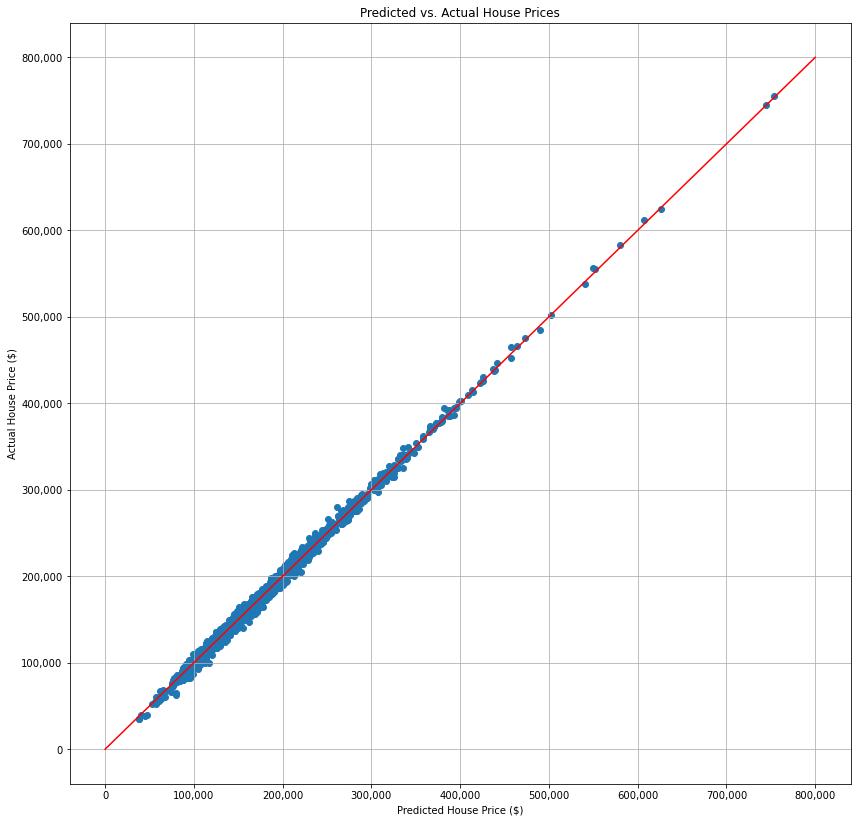

In [148]:
fig, ax = plt.subplots(1, figsize=(14, 14))
plt.scatter(x=y_pred, y=y);
plt.plot([0,800000], [0,800000], '-r');
plt.title("Predicted vs. Actual House Prices");
plt.xlabel("Predicted House Price ($)");
plt.ylabel("Actual House Price ($)");
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
ax.grid(visible=True)

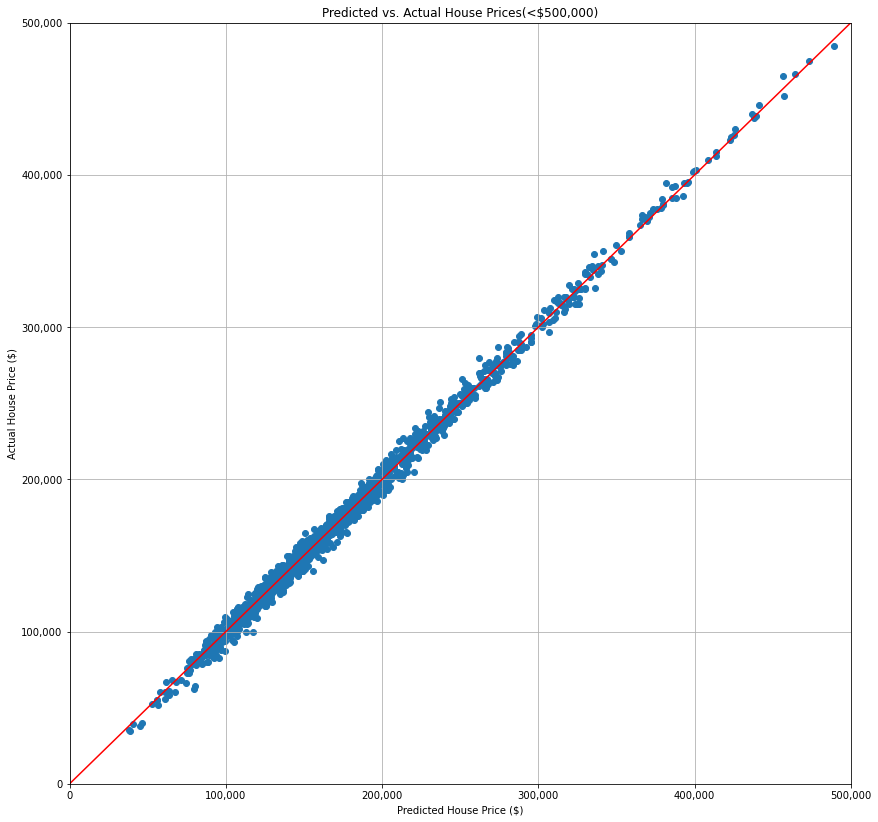

In [149]:
fig, ax = plt.subplots(1, figsize=(14, 14))
plt.scatter(x=y_pred, y=y);
plt.plot([0,500000], [0,500000], '-r');
plt.title("Predicted vs. Actual House Prices(<$500,000)");
plt.xlabel("Predicted House Price ($)");
plt.ylabel("Actual House Price ($)");
plt.xlim([0, 500000])
plt.ylim([0, 500000])
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
ax.grid(visible=True)

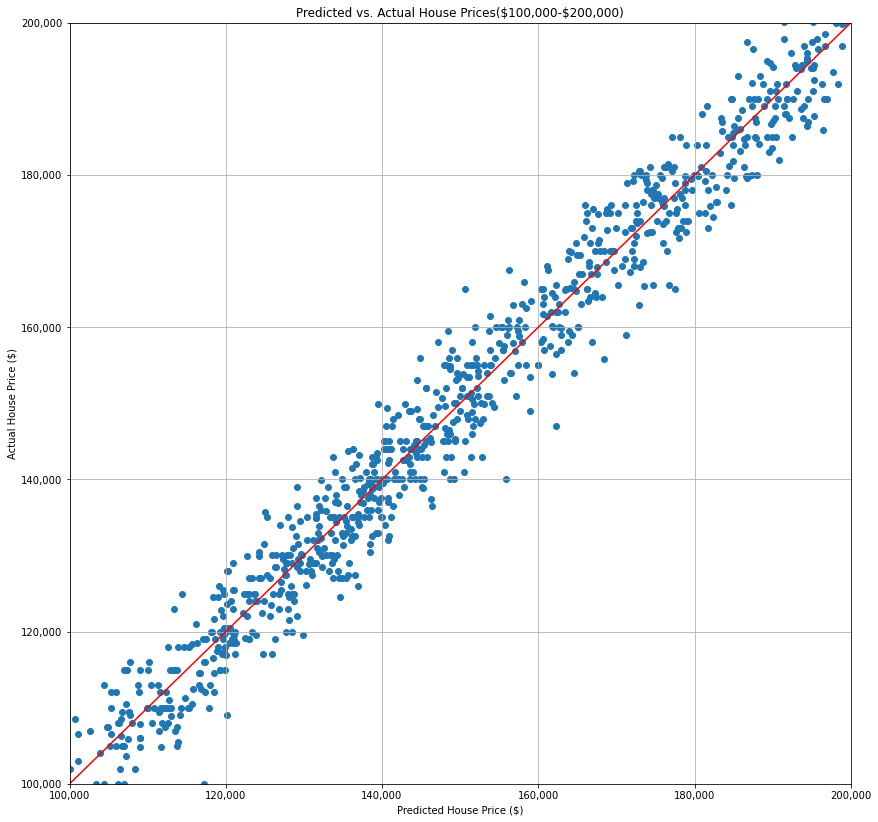

In [150]:
fig, ax = plt.subplots(1, figsize=(14, 14))
plt.scatter(x=y_pred, y=y);
plt.plot([100000,200000], [100000,200000], '-r');
plt.title("Predicted vs. Actual House Prices(\$100,000-\$200,000)");
plt.xlabel("Predicted House Price ($)");
plt.ylabel("Actual House Price ($)");
plt.xlim([100000, 200000])
plt.ylim([100000, 200000])
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
ax.grid(visible=True)

As seen from all plots, the model performed excellently as most of the house prices are close to the line of unity and roughly within ~$15,000 margin of error, without any considerable outliers to be found.

#### 7.3 Residual Plot

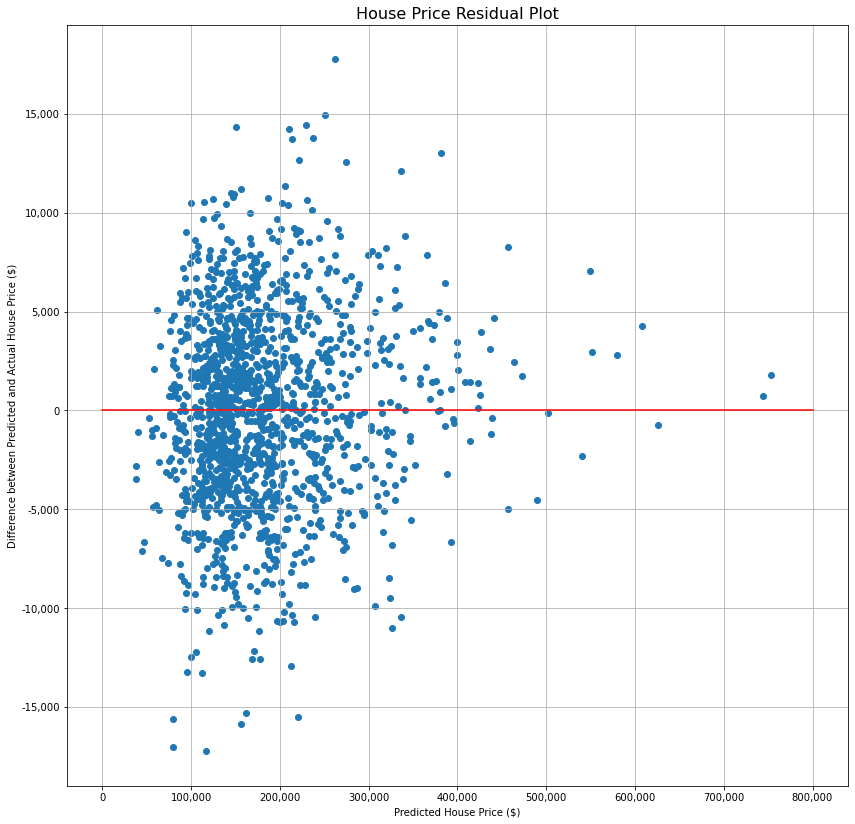

In [151]:
fig, ax = plt.subplots(1, figsize=(14, 14))
plt.scatter(x=y_pred, y=y-y_pred);
plt.plot([0,800000], [0,0], '-r');
plt.title("House Price Residual Plot", fontsize=16);
plt.xlabel("Predicted House Price ($)");
plt.ylabel("Difference between Predicted and Actual House Price ($)");
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
ax.grid(visible=True)

The residual plot shows the error between predicted house price to actual house price more pronounced. It is observable that most error tends to stay between -10,000 and +10,000, with the higher errors going beyond +15,000 or -15,000. 

## 8. Interpretation (Conclusion)

The goal of the proposal was to enter a Kaggle contest and employ multiple models and other tools like preprocessing to properly encode features with string value, and scaled numerical features for the for value-sensitive ML model such as SVR. As such, the original feature matrix shape after dropping some features was (1460, 75). After preprocessing the number columns increased mostly due to the encoding of OneHotEncoder and extended the shape of the feature matrix to (1460, 237).<br>

Once the feature was proprocessed and valid for model training, the following ML model was implemented: linear regression, support vector regressor, random forest regressor, gradient boosting regressor, and the ML model of interest XGBoost Regressor. The linear regressor and support vector regressor root mean-squared error were significantly higher than the decision tree ensemble methods and therefore were not selected for the hyperparameter tuning. In the initial model implementation, the gradient boosting regressor had performed the best, with a validation RMSE of -24560 in comparison to the XGBoost regressor with a validation RMSE of -25537 and the random forest regressor with a validaiton RMSE of -28304.<br>

It was relatively surprising to observe the XGBoost regressor did not perform as well as the gradient boosting regressor since the XGBR had more parameters to tune. However, although the initial implementation of XGBR was highly overfitting (training RMSE: -1577 vs. validation RMSE: -31034) the training RMSE was lower than the other two ensemble ML models, both training RMSE were within the tens of thousands range. XGBR in terms of parameters had a plethera of hyperparameters which could be used to fine tune the XGBR to find the optimal RMSE and reduce the overfitting that usually affects ensemble models early into implementation. With the above range in parameter for the grid search cross validaton, the combination was extensive enough to make the grid search execution take 2-3 hours to run. Therefore out of not wanting to cause the grid search execution time to increase exponentially, parameters chosen were limited to these selection. Most of the parameter range used for XGBoost Regressor was referenced by the Medium article mentioned above and seemed to have a positive effect, observing the validation RMSE reduction from -31034 to -25536. In summary, while more parameters could have been used to fine tune the XGBR better in the interest of time more features were not added and the implementation of XGBR was satisfied.<br> 

Finally, the gradient boosting regressor was chosen as the model with the best validation RMSE during the grid search and was used to predict the test dataset target vectors. R^2 score was also determined to present the severity of the RMSE in a more understandable value. The final validation RMSE and R^2 score from the training dataset was determined to be 4925 and 0.996. The final validation RMSE and R^2 score from predicting the test dataset was determined to be 4904 and 0.996. A predicted vs. actual house price plot and residual plot was determine to verify the R^2 score, where on the actual vs predicted plot, most of the house prices do not deviate erratically from the line of unity. Most points are within a 15,000 range, with most points clustering closer between 8000 to the line of unity range. No highly obvious outliers have been observed as well from the plot, meaning the model had fit well enough to catch enough of the features of each house and not predict a completely off house price.<br> 

As part of the interpretation and final part of competing in the Kaggle competition, the submission file will be created below and submitted to the competition:

In [152]:
id_list = np.asarray(house_price_test['Id']).reshape(-1,1)
pred_house_price_list = np.asarray(y_test_pred).reshape(-1, 1)
combined_sub = np.concatenate((id_list, pred_house_price_list), axis=1)
submission = pd.DataFrame(combined_sub, columns=["Id", "SalePrice"])
submission.to_csv("submission.csv")

After submission, the score received which was a root mean squared log error was 0.12824, and placed 1269th place out of 5080th. Therefore was placed in the top 25% percentile. (Leaderboard: https://www.kaggle.com/c/house-prices-advanced-regression-techniques/leaderboard#score Entry name: Deylin Yiao)

### 9. Reflection
In terms of any deviation from the initial proposal, initially the predicted model to be used in the kaggle competition was the XGBoost Regressor, but as it turns out (had tested submitting the XGBoostRegressor, the score had increased to 0.13 which is worse) the best model was the gradient boosting regressor. The deviation could have been dued to hyper parameter tuning as XGBoost had an excess of parameters and can be tested on an extensive range, but would take an excessive amount of time (one of the main drawbacks to XGBoost Regressor) and therefore did not pursue more exhaustive combinations. Some features within the feature matrix were dropped as they contained a significant amount of null values but could have been used to train the data, but would probably be not enough to improve XGBoost Regressor score. Other than the model selection, there were no other deviation as Kaggle provides a well supplemented dataset that only required basic preprocessing.